In [1]:
import pickle

In [295]:
with open("curves_by/fixed/112_b20_s100_lmin40_lmax_100_o15_six_hole_leaf.curves", 'rb') as pickle_file:
    curve_fragment = pickle.load(pickle_file)

In [296]:
cfs = [[],[],[],[],[],[],[],[],[]]
for cols in curve_fragment:
    for i in range(len(cols)):
        if i == 0:
            cfs[0] += cols[i]
        if i == 1:
            cfs[1] += cols[i]
        if i == 2:
            cfs[2] += cols[i]
        if i == 3:
            cfs[3] += cols[i]
        if i == 4:
            cfs[4] += cols[i]
        if i == 5:
            cfs[5] += cols[i]
        if i == 6:
            cfs[6] += cols[i]
        if i == 7:
            cfs[7] += cols[i]
        if i == 8:
            cfs[8] += cols[i]

<IPython.core.display.Javascript object>


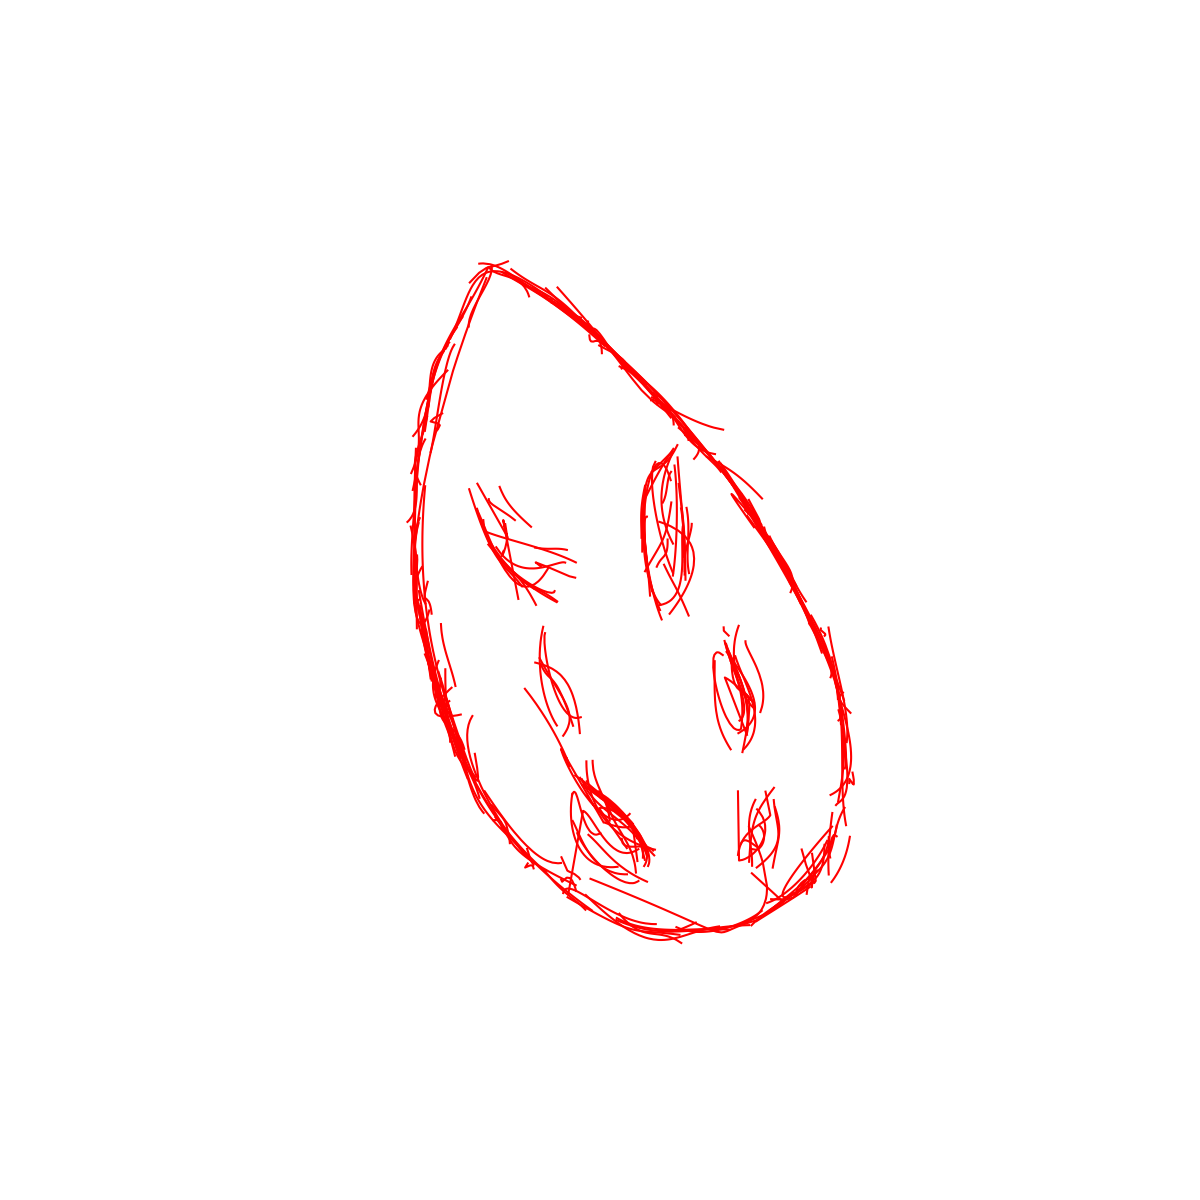

In [297]:
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
%matplotlib notebook

def plot_graph():
    color_arr = np.array([[255,0,0],[0,255,0],[0,0,255],
                             [255,255,0],[255,0,255],[0,255,255],
                             [127,127,127],[127,0,127],[0,127,127]],dtype = np.int16)
    j = 0
    for i in range(len(cfs)):
        for frag in cfs[i]:
            if frag.size == 0:
                continue
            #print(frag)
            
            
            x = frag[:,0]
            y = frag[:,1]
            z = frag[:,2]
            data = [x,y,z]
            try:
                tck, u= interpolate.splprep(data, k=3)
            except ValueError:
                pass
            except TypeError:
                pass
            new = interpolate.splev(u, tck, der=0)
            c = color_arr[i]/255
            if j % 100 == 0:
                ax.plot(new[0], new[2], new[1],"-",color=c)
            
            j+=1

        
        
        #ax.plot(x, z, y,"-")

fig = plt.figure(figsize = (12, 12))
fig.patch.set_alpha(0.)
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel("x", size = 14)
ax.set_ylabel("z", size = 14)
ax.set_zlabel("y", size = 14)
ax.set_box_aspect((1,1,1))

ax.axis("off")


plot_graph()

In [298]:
import itertools
import open3d as o3d

In [299]:
flatten_curve_frag = np.array(list(itertools.chain.from_iterable(cfs[0][::50])))
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(flatten_curve_frag)

In [301]:
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(
        pcd.cluster_dbscan(eps=0.0045, min_points=10, print_progress=True))

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([pcd])

[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 14
point cloud has 14 clusters


In [304]:
np.unique(labels, return_counts=True) # 0,1,4,5,7,8,9

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
       dtype=int32),
 array([  565, 12137,   878,    18,    14,  2247,   681,    19,  1529,
         1126,   315,    14,    10,     9,    13], dtype=int64))

<IPython.core.display.Javascript object>


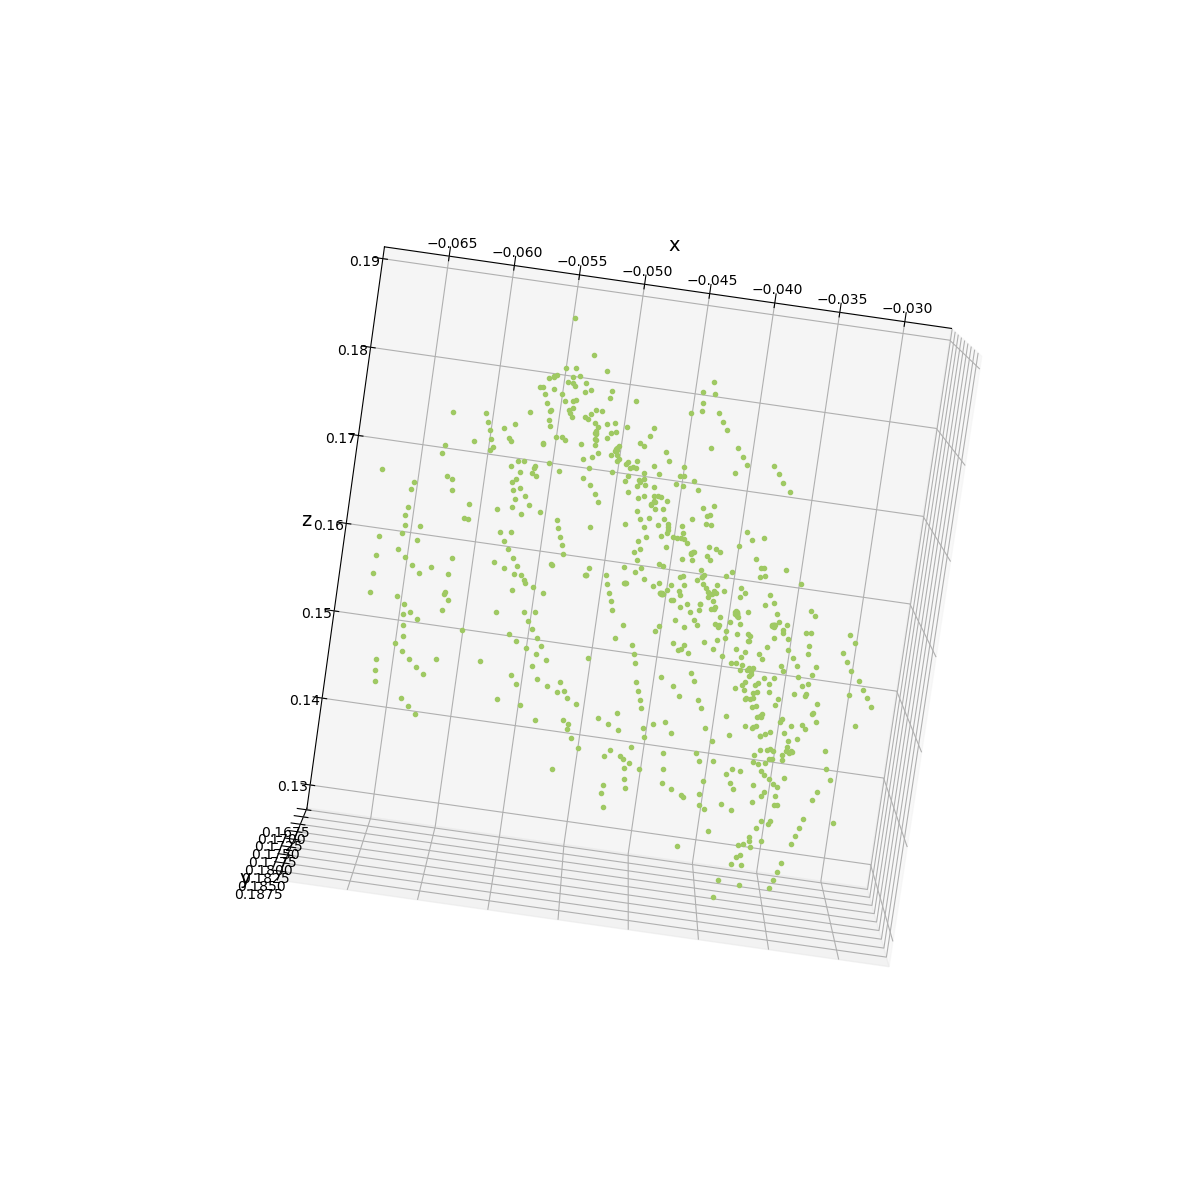

In [308]:
fig = plt.figure(figsize = (12, 12))
fig.patch.set_alpha(0.)
# 3DAxesを追加
ax = fig.add_subplot(111, projection='3d')

# 軸ラベルを設定
ax.set_xlabel("x", size = 14)
ax.set_ylabel("z", size = 14)
ax.set_zlabel("y", size = 14)
i = 0
for x,y,z in flatten_curve_frag[np.where(labels == 5)]:
    #if i%10==0:
    ax.plot(x, z, y,".",c="#9FC963")
    i+=1

In [221]:
import sklearn
from sklearn.decomposition import PCA

def PCA_show(flatten_curve_frag, labels, label_num):
    cluster = flatten_curve_frag[np.where(labels == label_num)]
    pca = PCA()
    pca.fit(cluster)
    feature = pca.transform(cluster)
    #plt.figure(figsize=(7, 7))
    #plt.scatter(feature[:, 0], feature[:, 1], alpha=0.8)
    #plt.grid()
    #plt.xlabel("PC1")
    #plt.ylabel("PC2")
    #plt.show()
    return cluster, feature

In [222]:
def sort_cluster(cluster, feature):
    r = (feature[:, 0]**2 + feature[:, 1]**2)**(1/2)
    cos = feature[:, 0]/r
    sin = feature[:, 1]/r

    arccos = np.arccos(cos)
    arcsin = np.arcsin(sin)
    arccos_m = -arccos
    arcsin_m = -np.pi -arcsin
    arcsin_p = np.pi - arcsin
    
    def same_checker(ls):
        for i, num1 in enumerate(ls):
            for j, num2 in enumerate(ls):
                if i == j:
                    continue
                if np.abs(num1 - num2) <0.0005:
                    return num1
    feature_theta = []
    for temp_list in zip(arccos, arcsin, arccos_m, arcsin_m, arcsin_p):
        theta = same_checker(temp_list)
        feature_theta.append(theta)
    feature_theta = np.array(feature_theta)
    cluster_ex_nan = cluster[np.where(feature_theta != None)]
    feature_theta_ex_nan = feature_theta[np.where(feature_theta != None)]
    sorted_idx = np.argsort(feature_theta_ex_nan)
    sorted_cluster = cluster_ex_nan[sorted_idx]
    return sorted_cluster

In [223]:
from scipy import interpolate
from scipy import ndimage

def b_splined(sorted_cluster, s=0.0387):
    x = sorted_cluster[:,0]
    y = sorted_cluster[:,2]
    z = sorted_cluster[:,1]
    data = [x,y,z]

    jump = np.sqrt(np.diff(x)**2 + np.diff(y)**2 + np.diff(z)**2) 
    smooth_jump = ndimage.gaussian_filter1d(jump, 5, mode='wrap')  # window of size 5 is arbitrary
    limit = 2*np.median(smooth_jump)    # factor 2 is arbitrary
    xn, yn, zn = x[:-1], y[:-1], z[:-1]
    xn = xn[(jump > 0) & (smooth_jump < limit)]
    yn = yn[(jump > 0) & (smooth_jump < limit)]
    zn = zn[(jump > 0) & (smooth_jump < limit)]

    data = [xn,yn,zn]
    tck, u = interpolate.splprep(data, s=s, k=3, per=1)
    new = interpolate.splev(u, tck, der=0)
    prossed_data = np.array(new)
    return prossed_data

In [224]:
def marge_prop(flatten_curve_frag, labels, label_num, s=0.15):
    cluster, feature = PCA_show(flatten_curve_frag, labels, label_num)
    sorted_cluster = sort_cluster(cluster, feature)
    prossed_data = b_splined(sorted_cluster, s=s)

    fig = plt.figure(figsize = (12, 12))
    fig.patch.set_alpha(0.)
    # 3DAxesを追加
    ax = fig.add_subplot(111, projection='3d')

    # 軸ラベルを設定
    ax.set_xlabel("x", size = 14)
    ax.set_ylabel("z", size = 14)
    ax.set_zlabel("y", size = 14)
    x, y, z = prossed_data[0],prossed_data[2],prossed_data[1]
    ax.plot(x, z, y,"-",c="#9FC963",linewidth = 7.0)
    return prossed_data

In [309]:
p_list = []

C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][11037]=x[0][0]
  (i, m, i)))
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][11037]=x[1][0]
  (i, m, i)))
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[2][11037]=x[2][0]
  (i, m, i)))


<IPython.core.display.Javascript object>


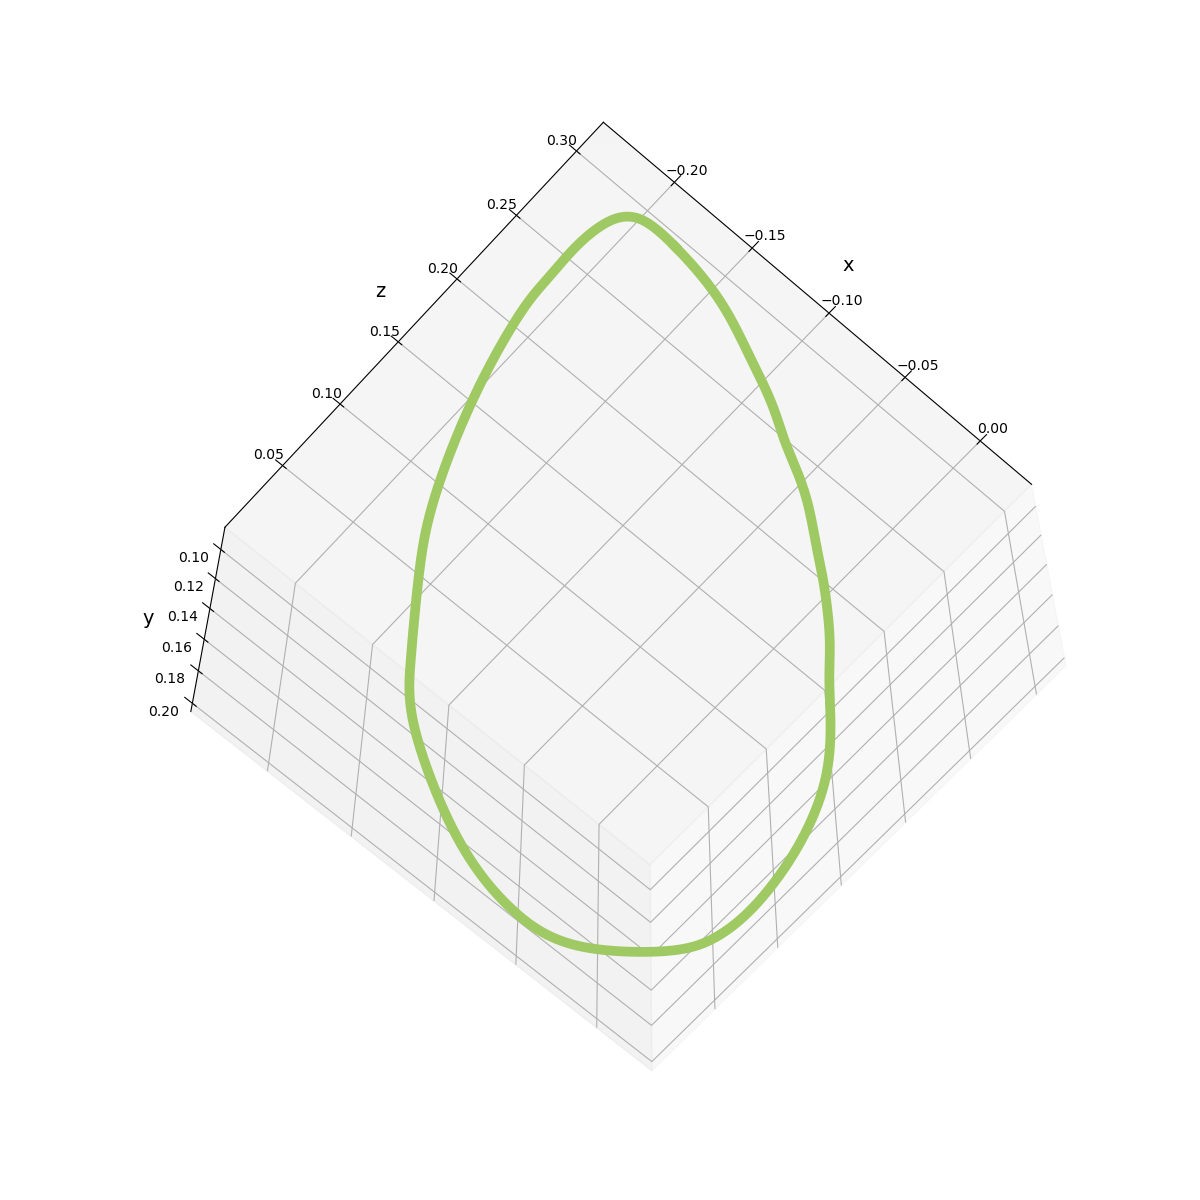

In [313]:
prossed_data = marge_prop(flatten_curve_frag, labels, 0, s=0.19)

In [314]:
p_list.append(prossed_data)

C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][836]=x[0][0]
  (i, m, i)))
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][836]=x[1][0]
  (i, m, i)))
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[2][836]=x[2][0]
  (i, m, i)))


<IPython.core.display.Javascript object>


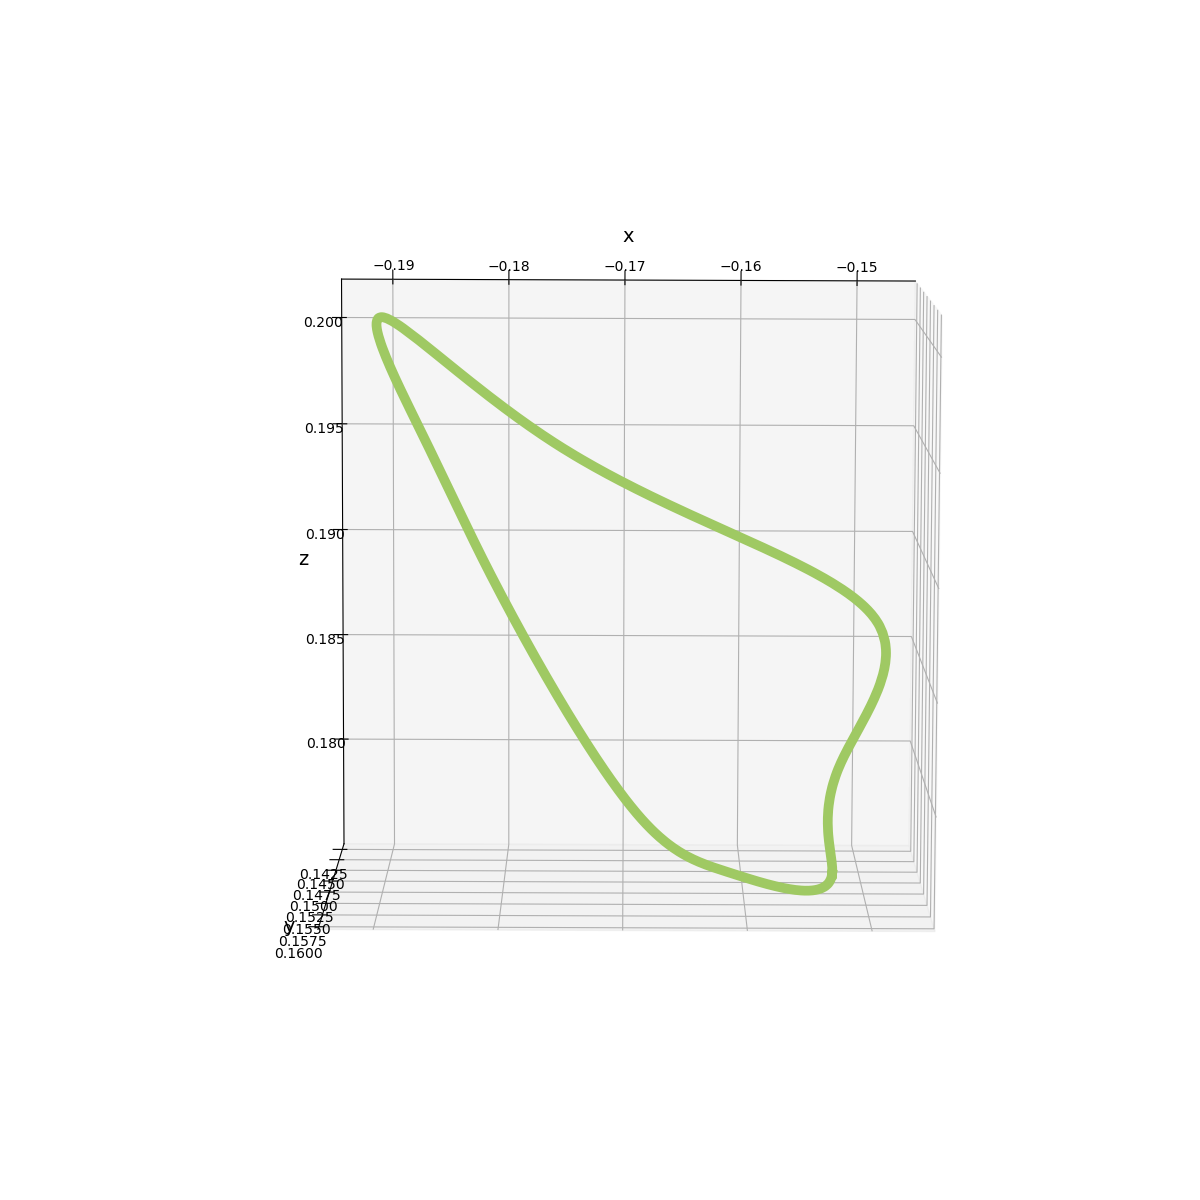

In [321]:
prossed_data = marge_prop(flatten_curve_frag, labels, 1, s=0.025)

In [322]:
p_list.append(prossed_data)

C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][2078]=x[0][0]
  (i, m, i)))
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][2078]=x[1][0]
  (i, m, i)))
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[2][2078]=x[2][0]
  (i, m, i)))


<IPython.core.display.Javascript object>


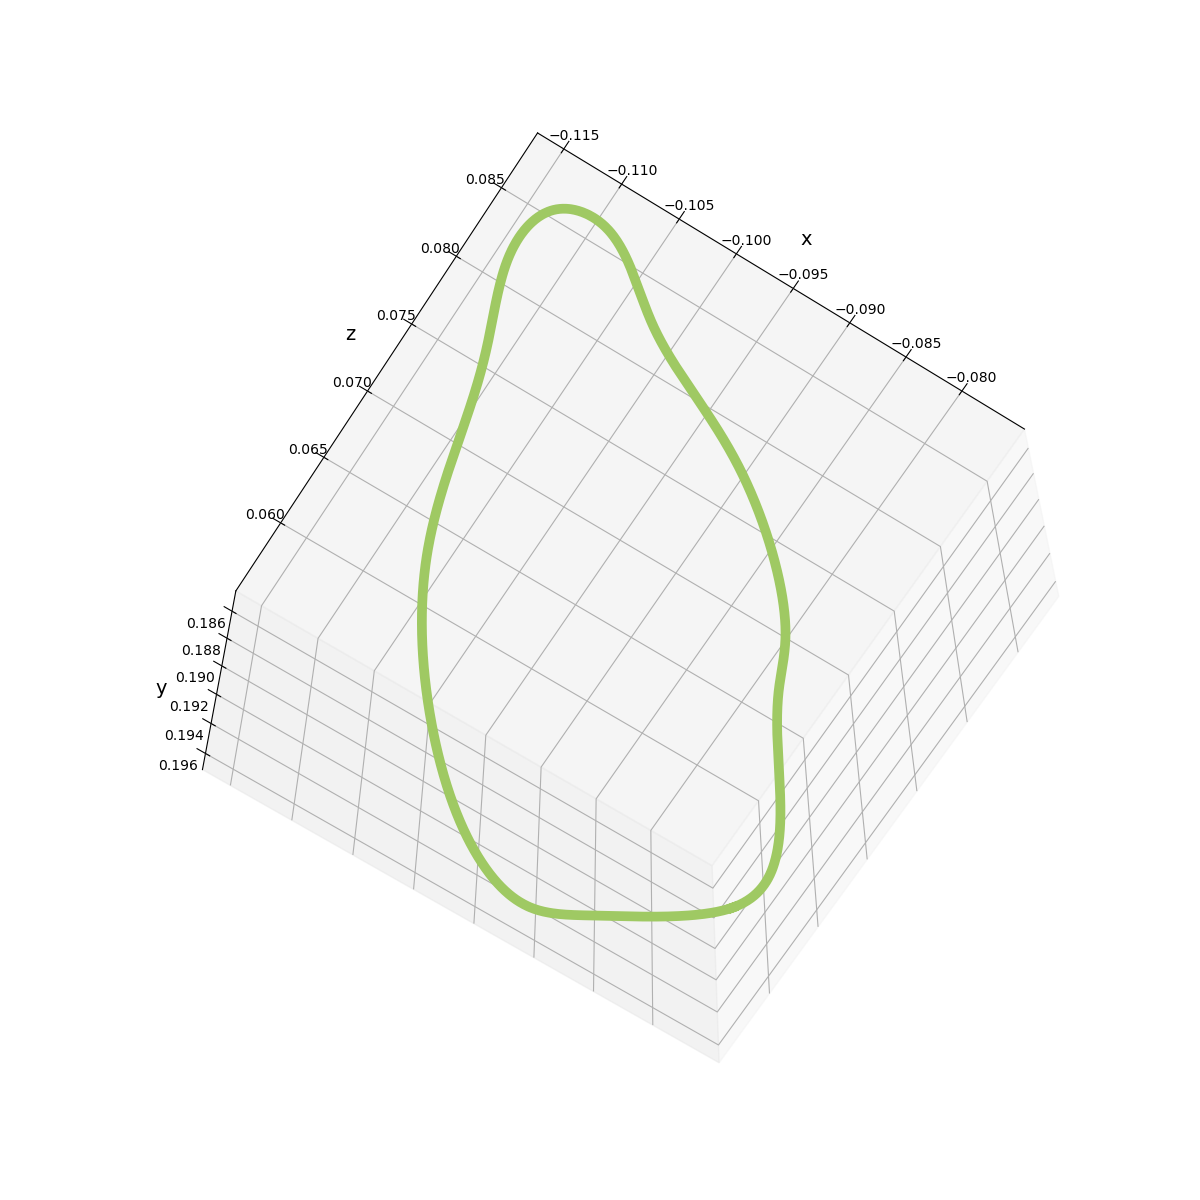

In [328]:
prossed_data = marge_prop(flatten_curve_frag, labels, 4, s=0.071)

In [329]:
p_list.append(prossed_data)

C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][680]=x[0][0]
  (i, m, i)))
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][680]=x[1][0]
  (i, m, i)))
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[2][680]=x[2][0]
  (i, m, i)))


<IPython.core.display.Javascript object>


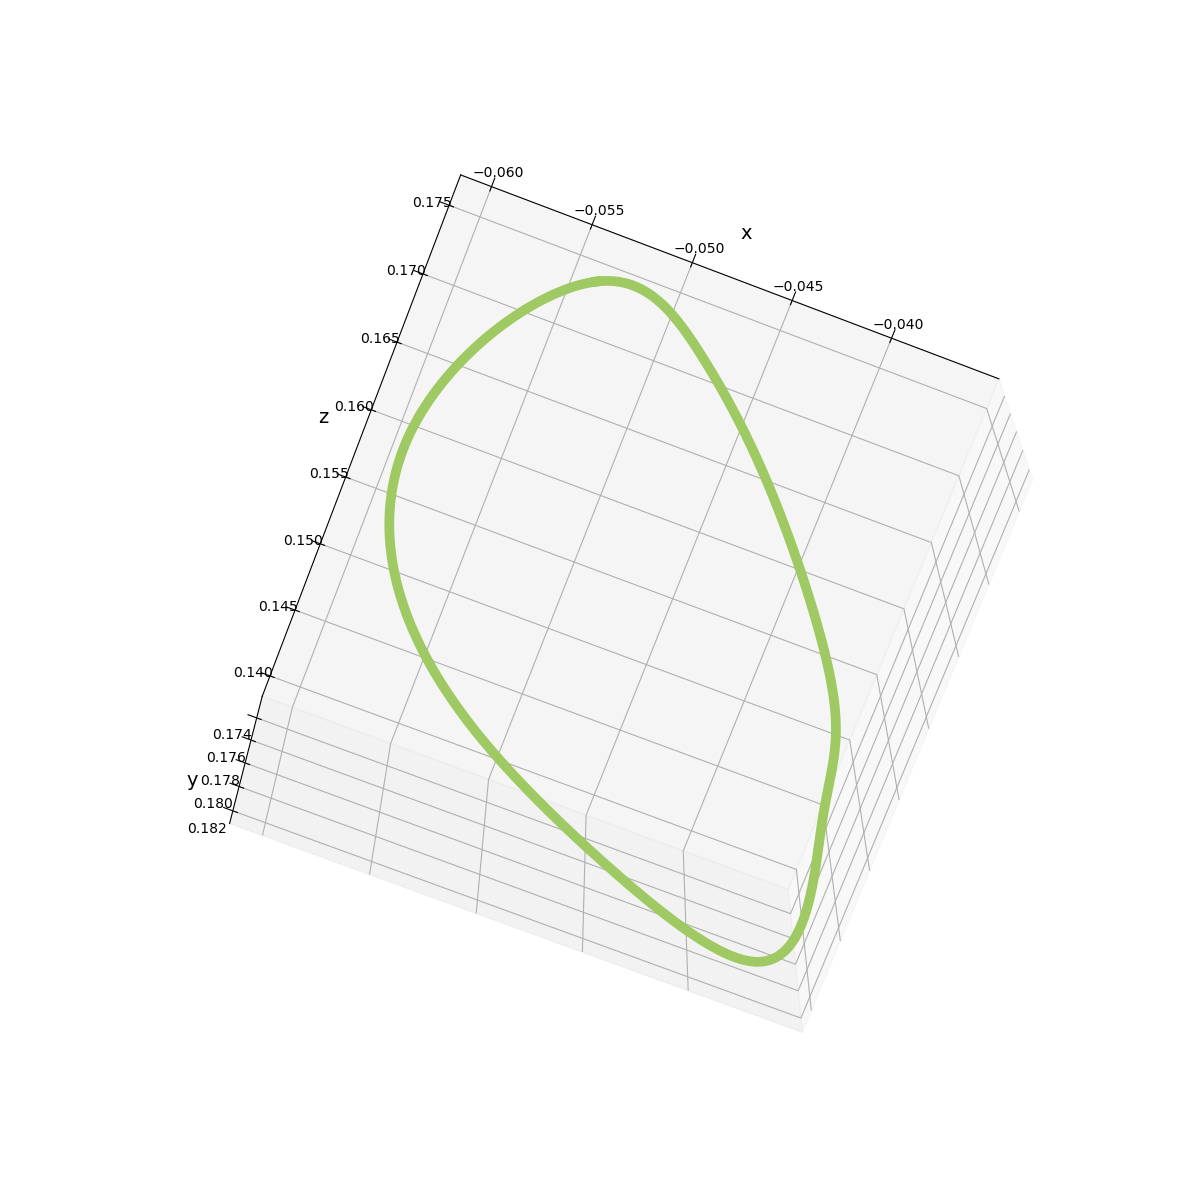

In [332]:
prossed_data = marge_prop(flatten_curve_frag, labels, 5, s=0.024)

In [333]:
p_list.append(prossed_data)

C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1374]=x[0][0]
  (i, m, i)))
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1374]=x[1][0]
  (i, m, i)))
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[2][1374]=x[2][0]
  (i, m, i)))


<IPython.core.display.Javascript object>


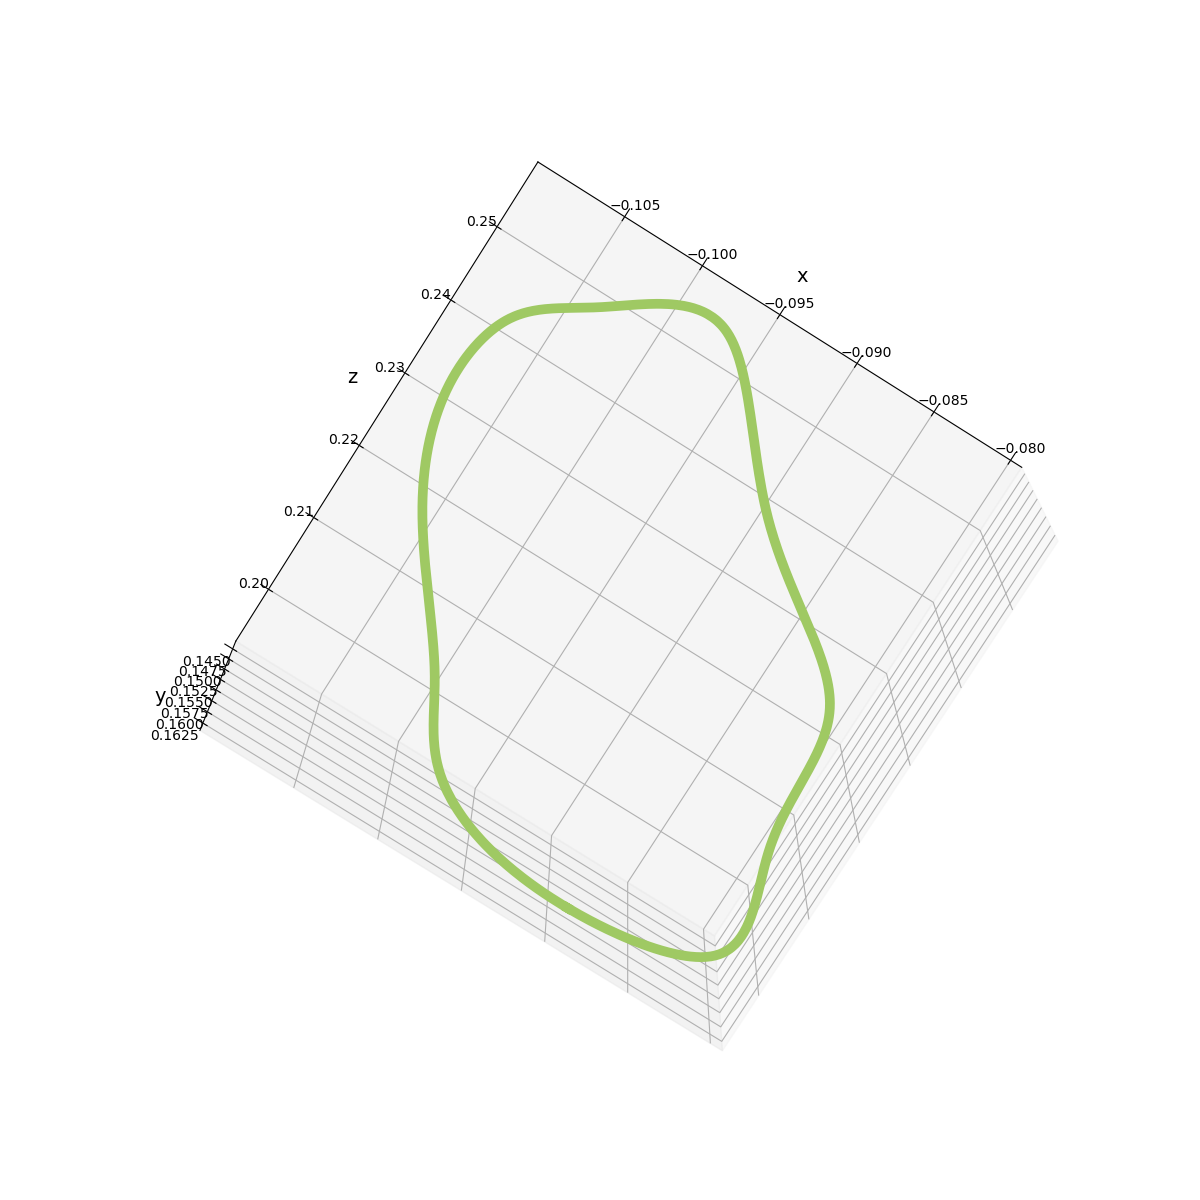

In [337]:
prossed_data = marge_prop(flatten_curve_frag, labels, 7, s=0.065)

In [338]:
p_list.append(prossed_data)

C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1036]=x[0][0]
  (i, m, i)))
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1036]=x[1][0]
  (i, m, i)))
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[2][1036]=x[2][0]
  (i, m, i)))


<IPython.core.display.Javascript object>


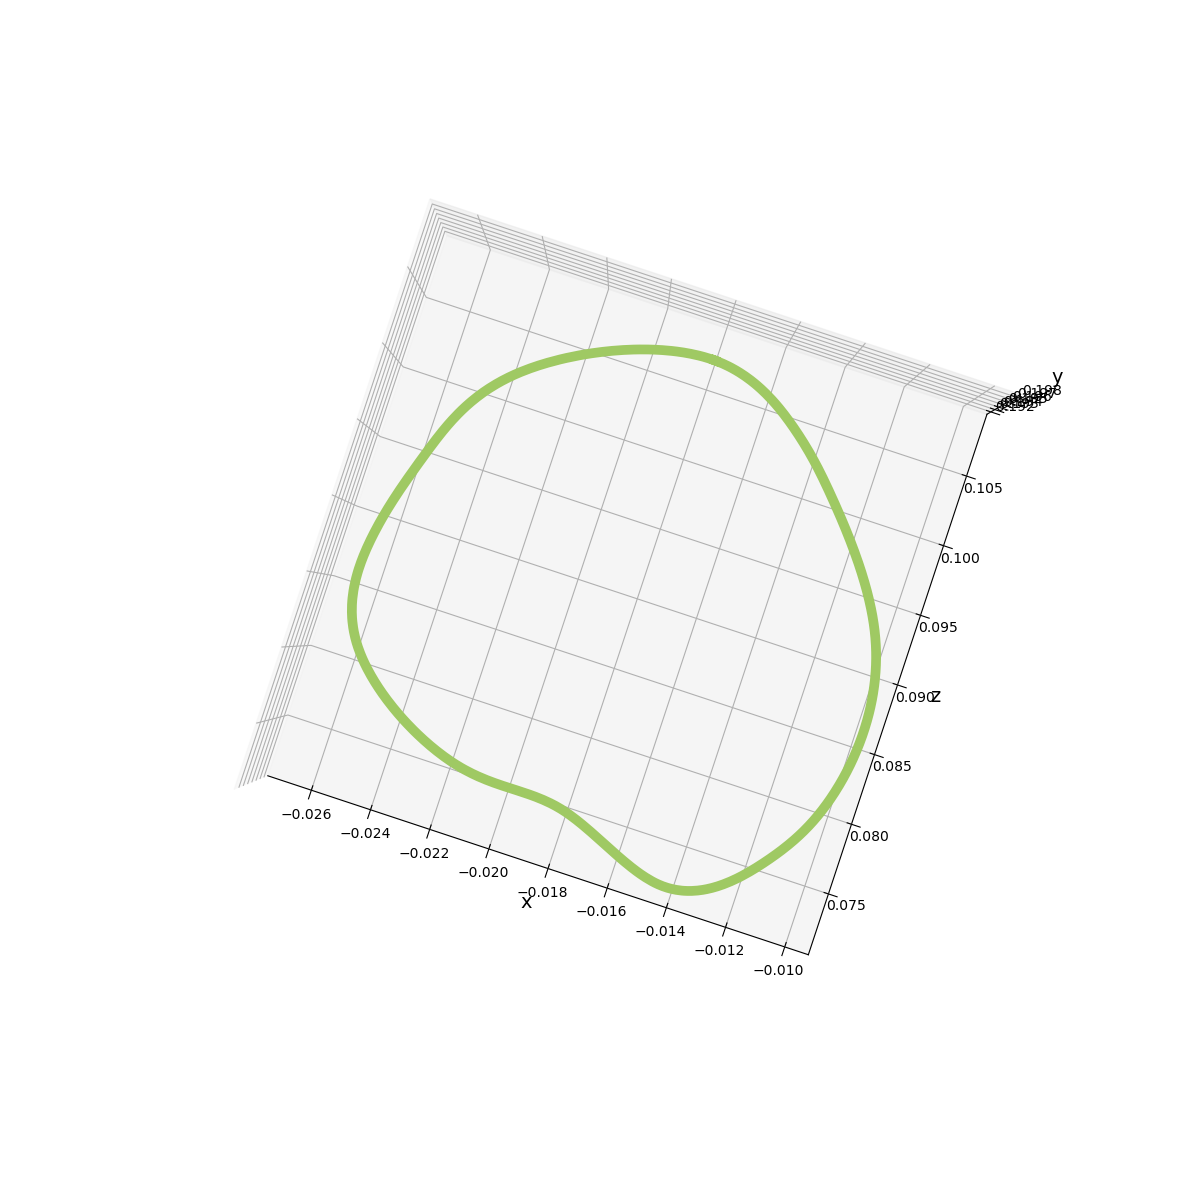

In [345]:
prossed_data = marge_prop(flatten_curve_frag, labels, 8, s=0.024)

In [346]:
p_list.append(prossed_data)

C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][314]=x[0][0]
  (i, m, i)))
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][314]=x[1][0]
  (i, m, i)))
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[2][314]=x[2][0]
  (i, m, i)))


<IPython.core.display.Javascript object>


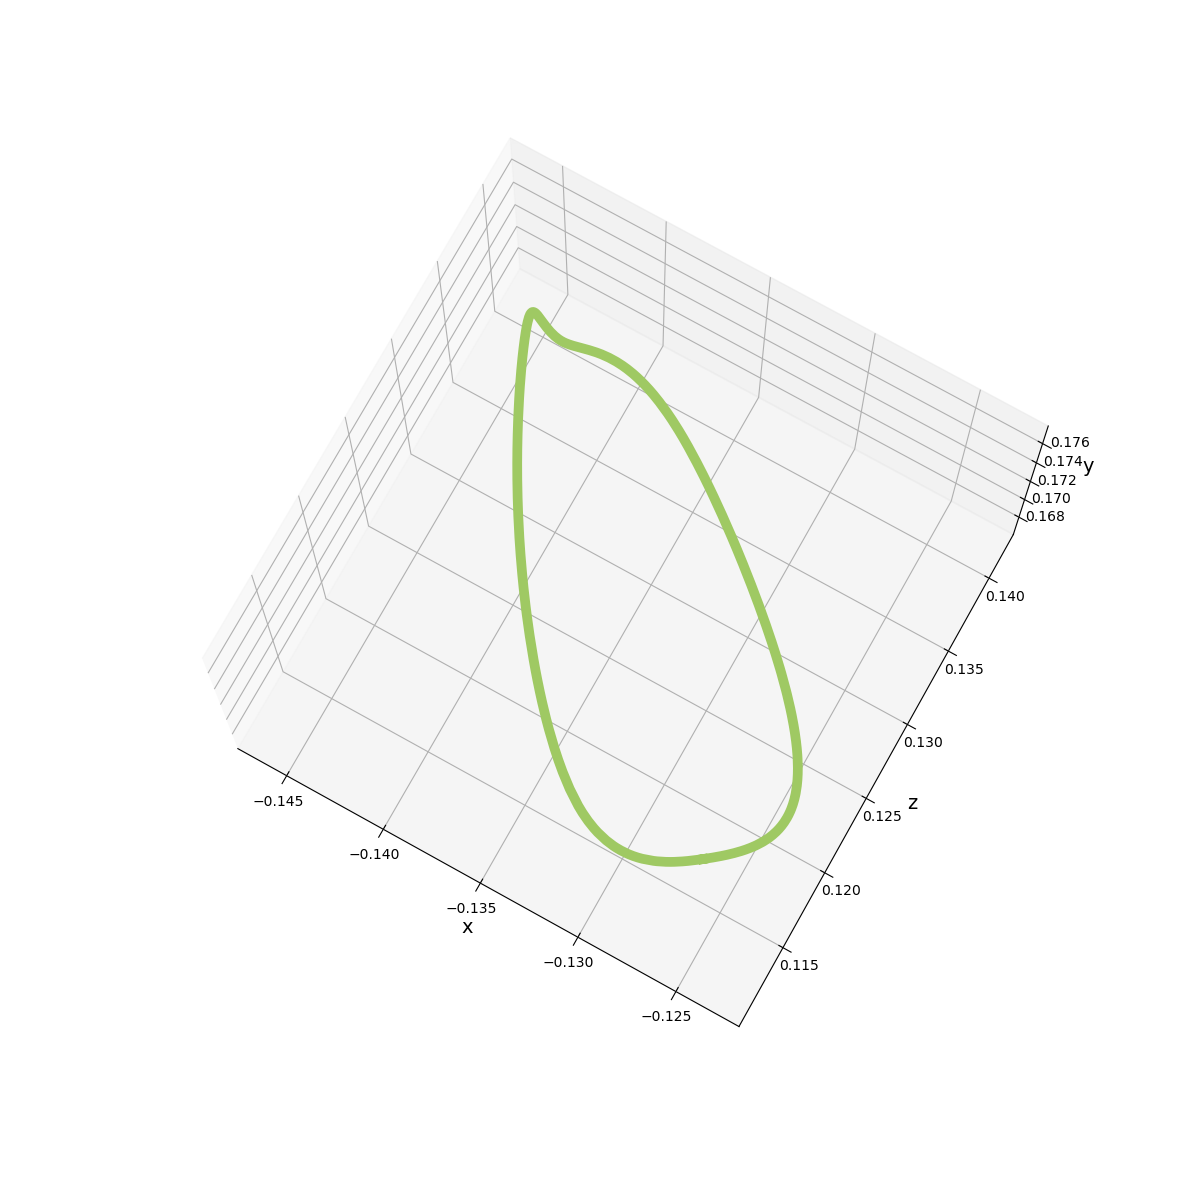

In [349]:
prossed_data = marge_prop(flatten_curve_frag, labels, 9, s=0.016)

In [350]:
p_list.append(prossed_data)

<IPython.core.display.Javascript object>


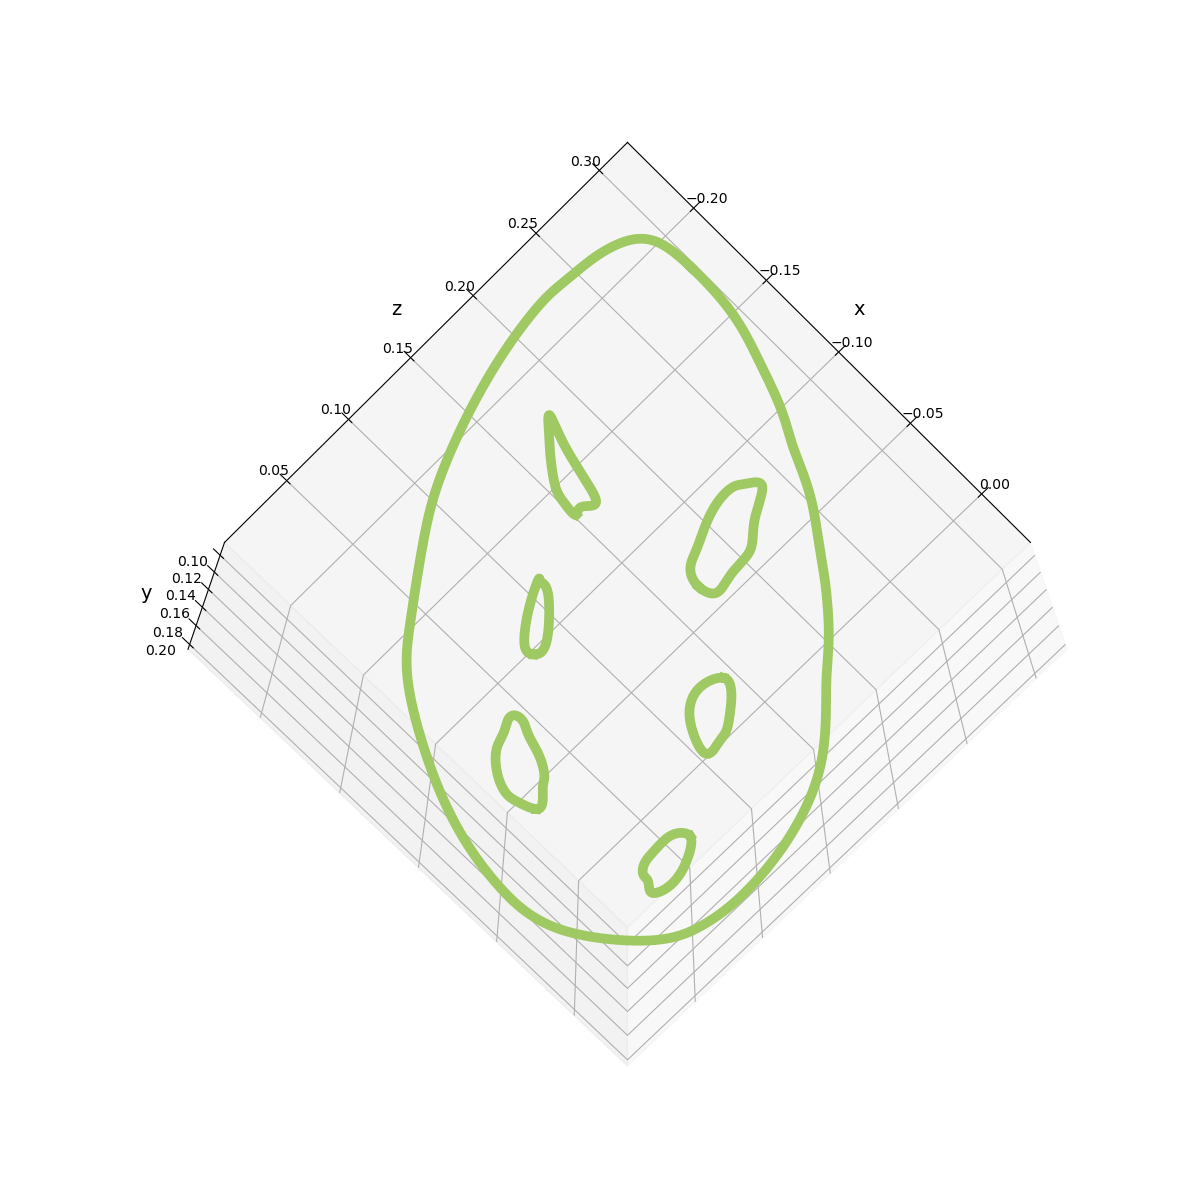

In [351]:
fig = plt.figure(figsize = (12, 12))
fig.patch.set_alpha(0.)
# 3DAxesを追加
ax = fig.add_subplot(111, projection='3d')

# 軸ラベルを設定
ax.set_xlabel("x", size = 14)
ax.set_ylabel("z", size = 14)
ax.set_zlabel("y", size = 14)
for curve in p_list:
    x, y, z = curve[0], curve[2], curve[1]
    ax.plot(x, z, y,"-",c="#9FC963",linewidth = 7.0)

plt.show()

In [352]:
import pickle
with open("curves_by/fixed/smoothed/s_112_b20_s100_lmin40_lmax_100_o15_six_hole_leaf.curves","wb") as f:
    pickle.dump(p_list, f)